# A/B sequence model

### initialize definitions

In [1]:
alutil::register.source(here::here("code/init.R"))
theme_set(tgppt::theme_arial(7))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘tgppt’


The following object is masked from ‘package:alutil’:

    vertical_labs



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/track_stats.csv'



# Get A/B meth data

In [2]:
cpg_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na  = 5)

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day4_cpg_meth.tsv'



In [3]:
nrow(cpg_meth)
colnames(cpg_meth)

[1] 132052

[1] "chrom"   "start"   "end"     "d0_3a"   "d0S_3a"  "d1_3a"   "d2_3a"  
 [8] "d3_3a"   "d4_3a"   "d0_3b"   "d0S_3b"  "d1_3b"   "d2_3b"   "d3_3b"  
[15] "d4_3b"   "d0_tko"  "d0S_tko" "d1_tko"  "d2_tko"  "d3_tko"  "d4_tko" 
[22] "d0_wt"   "d0S_wt"  "d1_wt"   "d2_wt"   "d3_wt"   "d4_wt"

In [4]:
m <- cpg_meth %>% 
    mutate(
        mA = psum(d1_3a, d2_3a, d3_3a, d4_3a, na.rm=FALSE),
        mB = psum(d1_3b, d2_3b, d3_3b, d4_3b, na.rm=FALSE),
        mwt = psum(d1_wt, d2_wt, d3_wt, d4_wt, na.rm=FALSE),
        dAB = mA - mB,
        dB = mB - mwt, 
        dA = mA - mwt    
    ) %>% 
    select(chrom, start, end, mA, mB, mwt, dAB, dB, dA)

#### Clean loci with 0 methylation:

In [5]:
locus_means <- rowMeans(cpg_meth %>% select(-(chrom:end)), na.rm=TRUE)
locus_sds <- matrixStats::rowSds(cpg_meth %>% select(-(chrom:end)) %>% as.matrix() , na.rm=TRUE)

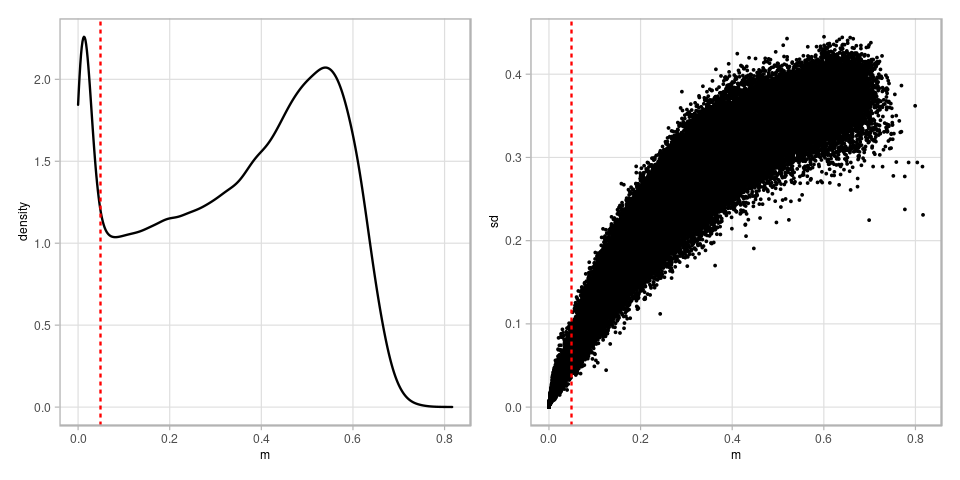

In [6]:
options(repr.plot.width = 8, repr.plot.height = 4)
thresh <- 0.05
p1 <- tibble(m = locus_means) %>% ggplot(aes(x=m)) + geom_density() + geom_vline(xintercept=thresh, linetype="dashed", color="red")
p2 <- tibble(m = locus_means, sd = locus_sds) %>% ggplot(aes(x=m, y=sd)) + geom_point(size=0.01) + geom_vline(xintercept=thresh, linetype="dashed", color="red")
p1 + p2

In [7]:
m <- m[locus_means >= thresh, ]

In [8]:
sum(locus_means < thresh)
nrow(m)

[1] 15935

[1] 116117

In [9]:
fwrite(m, here("output/ebd_day1_to_day4_cpg_meth_mat.tsv"), sep="\t")

## Calculate models

In [10]:
intervs_all <- m %>% select(chrom, start, end)

In [11]:
flank_bp <- 5
seq_df <- get_seq_df(intervs_all, flank_bp = flank_bp)

In [12]:
head(seq_df)

chrom,start,end,nuc,pos,dnuc
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,4402515,4402516,G,2,GG
chr1,4402515,4402516,G,3,GG
chr1,4402515,4402516,G,4,GA
chr1,4402515,4402516,A,5,AA
chr1,4402515,4402516,A,6,AG
chr1,4402515,4402516,G,9,GC


In [13]:
seq_df_wide <- seq_df_to_wide(seq_df, flank_bp = 5)
seq_df_wide_nuc <- seq_df_to_wide(seq_df, flank_bp = 5, dinuc=FALSE)

In [14]:
# f_wt <- cpg_meth %>% filter(d4_wt >= 0.75 & d4_wt <= 0.85) %>% select(chrom:end)
# f_wt <- m %>% mutate(i = 1:n()) %>% inner_join(f_wt) %>% pull(i)
# length(f_wt)

#### Compute models

hyperparameters tuning:

In [15]:
xgb_params <- hypertune_xgb(seq_df_wide, m, dAB) %cache_rds% here("data/xgb_params.rds")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/data/xgb_params.rds'



In [16]:
xgb_params

$params
$params$booster
[1] "gbtree"

$params$objective
[1] "reg:squarederror"

$params$subsample
[1] 1

$params$max_depth
[1] 4

$params$colsample_bytree
[1] 0.4

$params$gamma
[1] 0.1

$params$eta
[1] 0.05

$params$eval_metric
[1] "rmse"

$params$min_child_weight
[1] 2


$nrounds
[1] 1750

In [17]:
message("dAB (dinuc)")
model_ab <- gen_seq_model(seq_df_wide, m, dAB) %cache_rds% here("output/ab_dinuc_model_5bp.rds")

model_ab_xgboost <- gen_seq_model_xgboost(seq_df_wide, m, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_xgboost.rds")

message("dAB (nuc)")
model_ab_nuc <- gen_seq_model(seq_df_wide_nuc, m, dAB) %cache_rds% here("output/ab_nuc_model_5bp.rds")
model_ab_nuc_xgboost <- gen_seq_model_xgboost(seq_df_wide_nuc, m, dAB, xgb_params) %cache_rds% here("output/ab_nuc_model_5bp_xgboost.rds")

message("dA")
model_a <- gen_seq_model(seq_df_wide, m, dA) %cache_rds% here("output/a_dinuc_model_5bp.rds")
model_a_xgboost <- gen_seq_model_xgboost(seq_df_wide, m, dA, xgb_params) %cache_rds% here("output/a_dinuc_model_5bp_xgboost.rds")
# model_ma_xgboost <- gen_seq_model_xgboost(seq_df_wide, m, mA, xgb_params) %cache_rds% here("output/ma_dinuc_model_5bp_xgboost.rds")

message("dB")
model_b <- gen_seq_model(seq_df_wide, m, dB) %cache_rds% here("output/b_dinuc_model_5bp.rds")
model_b_xgboost <- gen_seq_model_xgboost(seq_df_wide, m, dB, xgb_params) %cache_rds% here("output/b_dinuc_model_5bp_xgboost.rds")
# model_mb_xgboost <- gen_seq_model_xgboost(seq_df_wide, m, mB, xgb_params) %cache_rds% here("output/mb_dinuc_model_5bp_xgboost.rds")

dAB (dinuc)

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost.rds'

dAB (nuc)

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_nuc_model_5bp.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_nuc_model_5bp_xgboost.rds'

dA

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/a_dinuc_model_5bp.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/a_dinuc_model_5bp_xgboost.rds'

dB

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/b_dinuc_model_5bp.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/b_dinuc_model_5bp_xgboost.rds'



#### Plot models vs preditions

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")



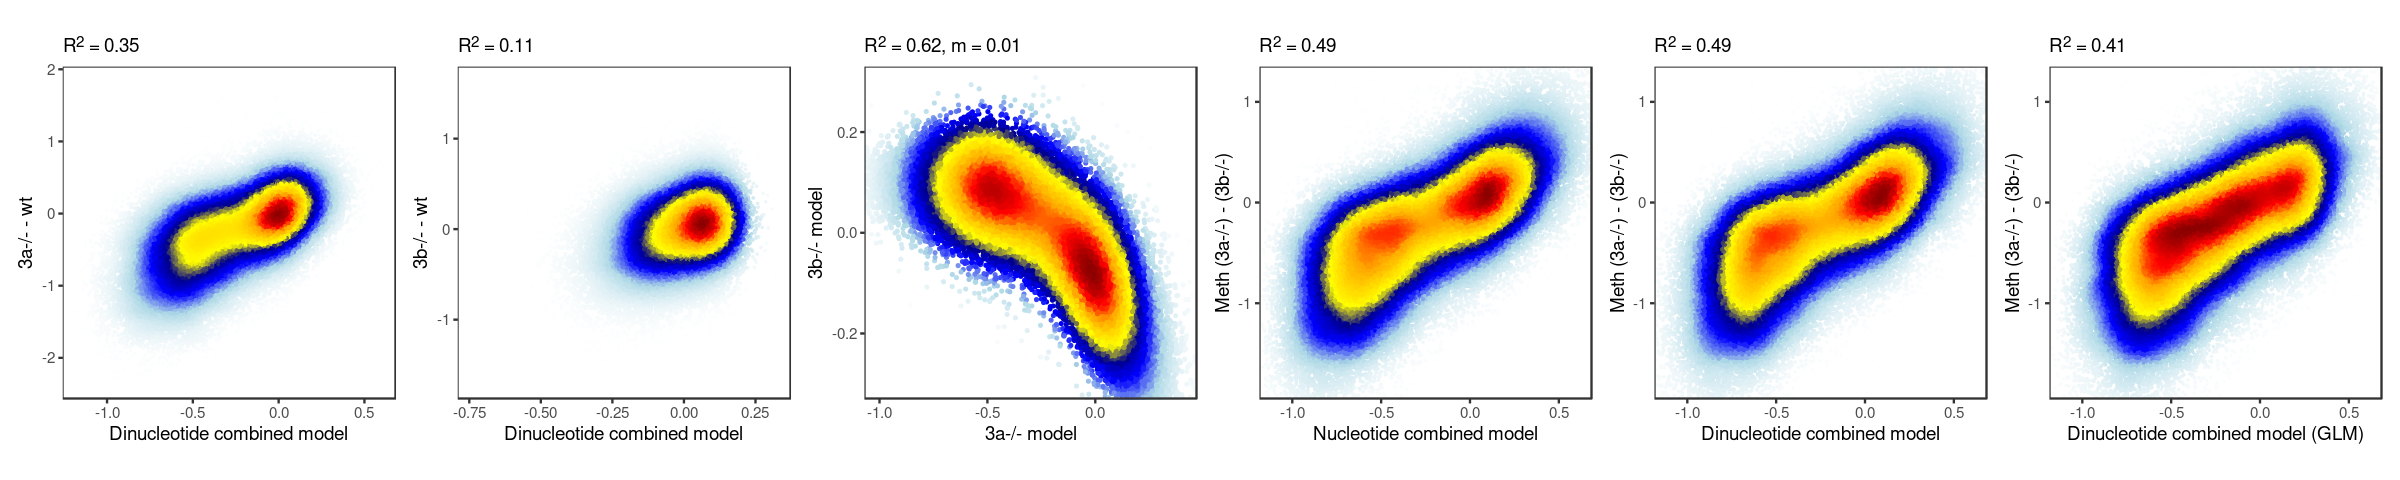

In [18]:
options(repr.plot.width = 20, repr.plot.height=4)

p_ab_glm <- plot_model_scatter(model_ab, x_lab="Dinucleotide combined model (GLM)", y_lab = "Meth (3a-/-) - (3b-/-)", xlim=c(-1.1, 0.6), ylim= c(-1.8, 1.2))
p_ab <- plot_model_scatter(model_ab_xgboost, x_lab="Dinucleotide combined model", y_lab = "Meth (3a-/-) - (3b-/-)", xlim=c(-1.1, 0.6), ylim= c(-1.8, 1.2))
p_ab_nuc <- plot_model_scatter(model_ab_nuc_xgboost, x_lab="Nucleotide combined model", y_lab = "Meth (3a-/-) - (3b-/-)", xlim=c(-1.1, 0.6), ylim= c(-1.8, 1.2))
p_a <- plot_model_scatter(model_a_xgboost, x_lab="Dinucleotide combined model", y_lab = "3a-/- - wt")
p_b <- plot_model_scatter(model_b_xgboost, x_lab="Dinucleotide combined model", y_lab = "3b-/- - wt")

fa_b <- model_a$mat %>% select(chrom:end) %>% mutate(i = 1:n()) %>% inner_join(model_b$mat %>% select(chrom, start, end)) %>% pull(i)
fb_a <- model_b$mat %>% select(chrom:end) %>% mutate(i = 1:n()) %>% inner_join(model_a$mat %>% select(chrom, start, end)) %>% pull(i)
p_models <- tibble(model_a = model_a_xgboost$pred[fa_b], model_b = model_b_xgboost$pred[fb_a]) %>% 
    mutate(col = densCols(., bandwidth=0.08,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=model_a, y=model_b, col=col)) + 
        geom_point(shape=19, size=0.4) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-1, 0.4), ylim = c(-0.3, 0.3)) +         
        xlab("3a-/- model") + 
        ylab("3b-/- model") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("R^2 = {cor}, m = {meth_cor}", cor = round(cor(model_a_xgboost$pred[fa_b], model_b_xgboost$pred[fb_a])^2, digits=2), meth_cor = round(cor(model_a_xgboost$mat$dA[fa_b], model_b_xgboost$mat$dB[fb_a])^2, digits=2)))



p <- p_a + p_b + p_models + p_ab_nuc + p_ab + p_ab_glm + plot_layout(nrow=1)
p & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())


In [19]:
tgppt::plot_gg_ppt(p_a + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3, top = 9.7, overwrite=TRUE)
tgppt::plot_gg_ppt(p_b + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 5, top = 9.7)
tgppt::plot_gg_ppt(p_ab + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 10, top = 9.7)

tgppt::plot_gg_ppt(p_ab_glm + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 10, top = 5)

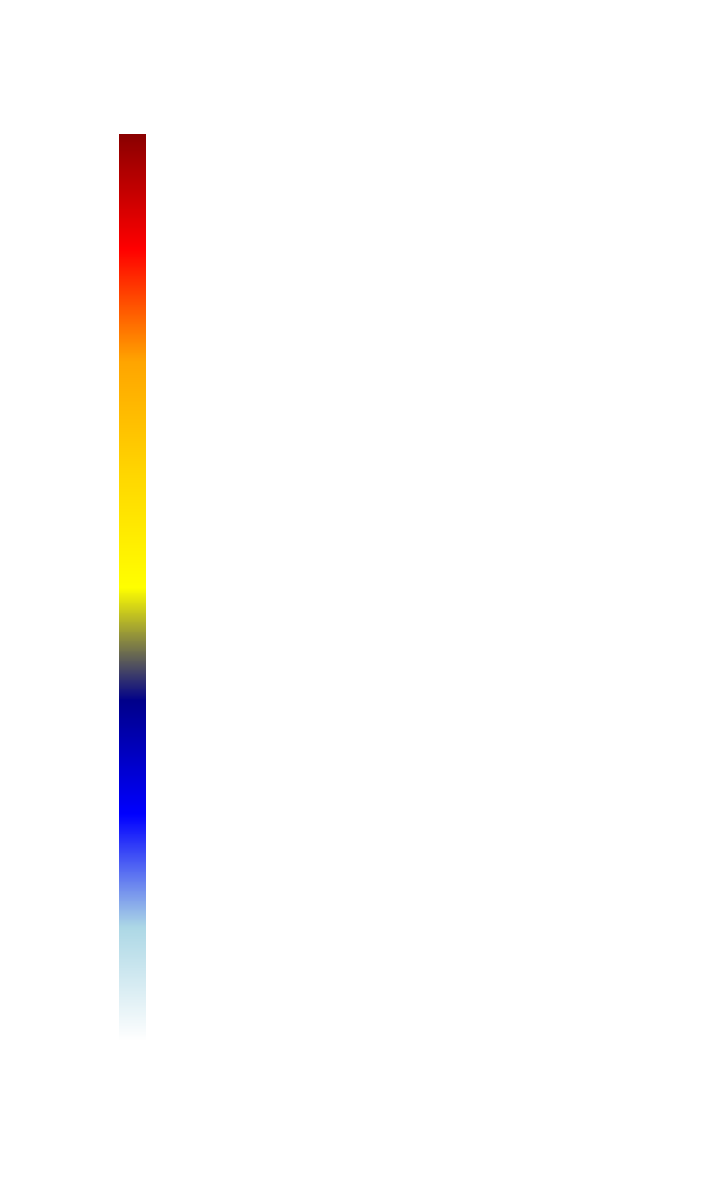

In [20]:
options(repr.plot.width = 6, repr.plot.height=10)
plot_model_scatter_legend(model_ab)

### Plot GLM model parameters

In [20]:
coef_df <- get_coef_df(model_ab)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1



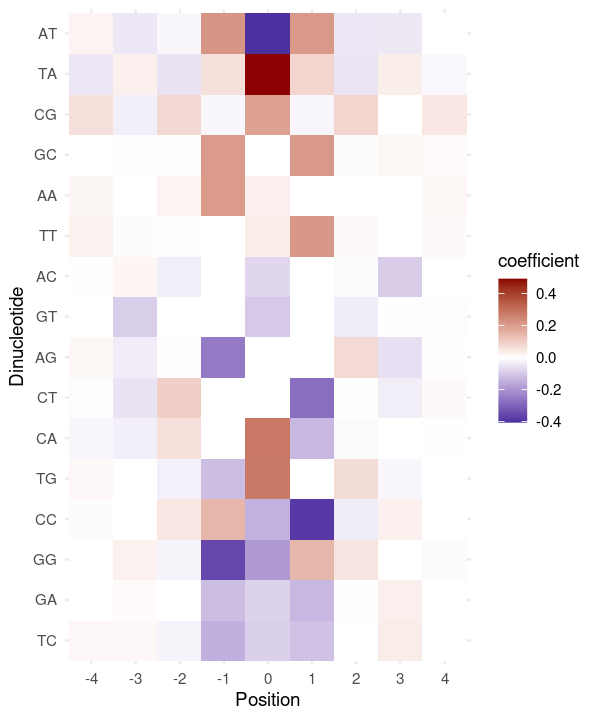

In [21]:
options(repr.plot.width = 5, repr.plot.height = 6)
p <- coef_df %>% 
    ggplot(aes(x=pos, y=dinuc, fill=coefficient)) + 
        geom_tile() + 
        scale_fill_gradient2(low = "darkblue", high = "darkred", mid = "white", midpoint = 0, na.value="white") + 
        theme_minimal() + 
        ylab("Dinucleotide") + 
        xlab("Position")
p

In [22]:
tgppt::plot_gg_ppt(p + guides(fill=FALSE) + theme_arial(7) + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model_mat.pptx"), rasterize_plot=TRUE, width = 5, height = 3.5, left = 1.3, top = 9.7, overwrite=TRUE)

#### plot logo

In [66]:
# library(ggseqlogo)

In [23]:
ab_score_quant <- gquantiles("DNMT.ab_score_glm_plus", c(0.1,0.9))
high_score_df <- gscreen("DNMT.ab_score_glm_plus >= ab_score_quant[2]", intervals=gintervals.all()) %>% mutate(start = start - 5, end = end + 6) %>% mutate(s = toupper(gseq.extract(.))) %>% as_tibble() 
low_score_df <- gscreen("DNMT.ab_score_glm_plus <= ab_score_quant[1]", intervals=gintervals.all()) %>% mutate(start = start - 5, end = end + 6) %>% mutate(s = toupper(gseq.extract(.))) %>% as_tibble() 

In [24]:
high_score_df1 <- high_score_df %>% 
    mutate(
        r1 = sample(c("A", "C", "G", "T"), size=length(s), replace=TRUE), 
        r2 = sample(c("A", "C", "G", "T"), size=length(s), replace=TRUE)) %>% 
    unite("r", r1, r2, sep="") %>% 
    mutate(i = 1:n(), r = ifelse(i <= length(s) * 0.8, "CG", r)) %>% 
    mutate(s1 = paste0(substr(s, 1, 5), r, substr(s, 8, length(s)))) %>% 
    select(chrom, start, end, s = s1)

In [25]:
low_score_df1 <- low_score_df %>% 
    mutate(
        r1 = sample(c("A", "C", "G", "T"), size=length(s), replace=TRUE), 
        r2 = sample(c("A", "C", "G", "T"), size=length(s), replace=TRUE)) %>% 
    unite("r", r1, r2, sep="") %>% 
    mutate(i = 1:n(), r = ifelse(i <= length(s) * 0.8, "CG", r)) %>% 
    mutate(s1 = paste0(substr(s, 1, 5), r, substr(s, 8, length(s)))) %>% 
    select(chrom, start, end, s = s1)

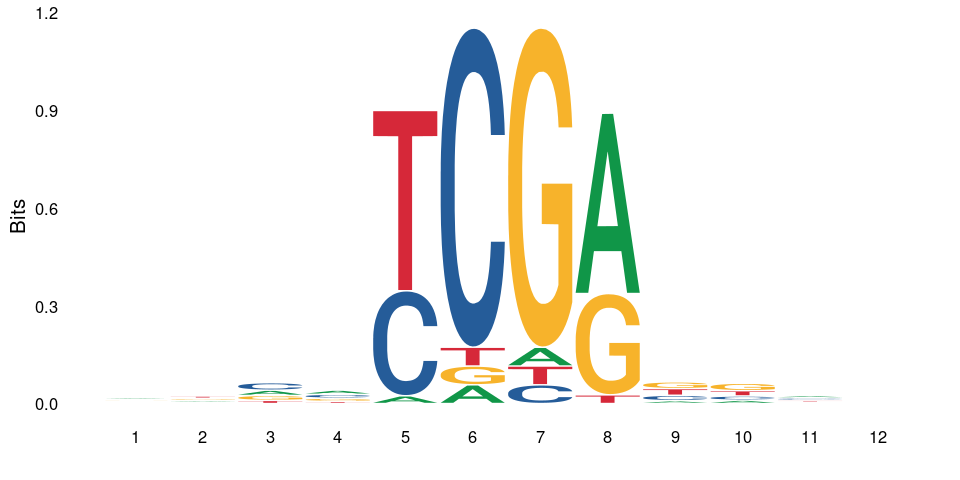

In [27]:
options(repr.plot.width = 8, repr.plot.height = 4)
p_high <- ggplot() + ggseqlogo::geom_logo(high_score_df1$s, method="bits", seq_type="dna") + ggseqlogo::theme_logo()
p_high

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



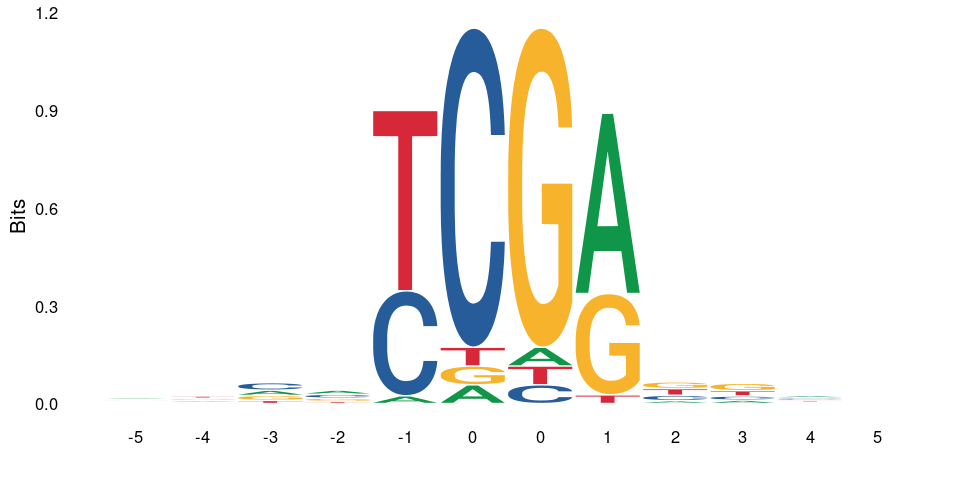

In [28]:
p_high <- p_high + scale_x_continuous(labels = c(-5:-1, 0, 0, 1:5), breaks=1:12)
p_high

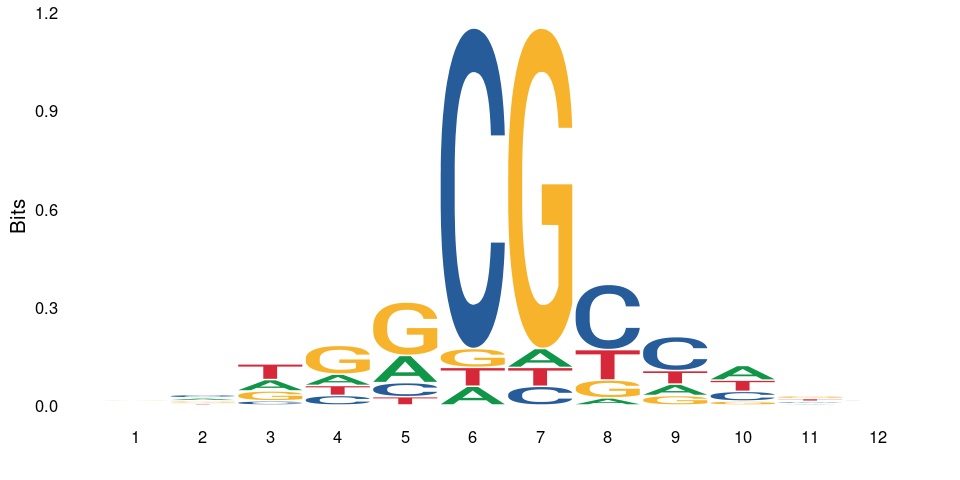

In [29]:
options(repr.plot.width = 8, repr.plot.height = 4)
p_low <- ggplot() + ggseqlogo::geom_logo(low_score_df1$s, method="bits", seq_type="dna") + ggseqlogo::theme_logo()
p_low

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



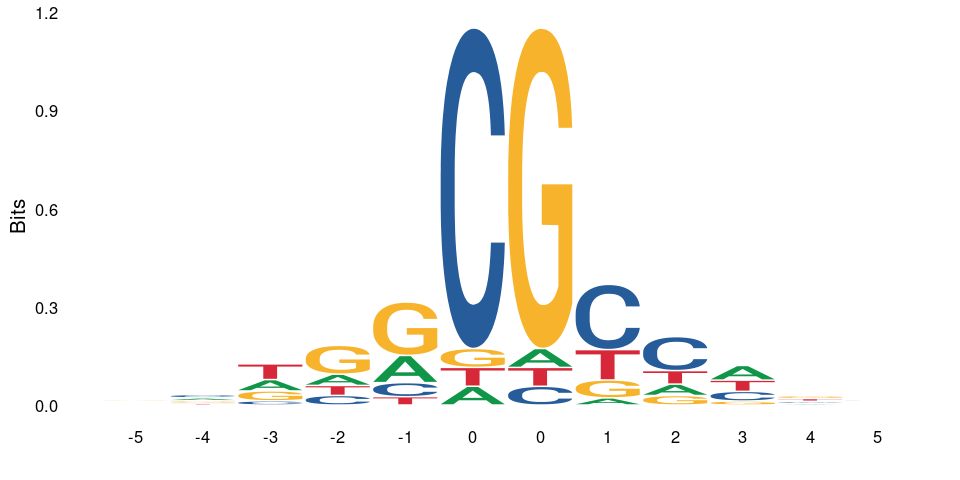

In [30]:
p_low <- p_low + scale_x_continuous(labels = c(-5:-1, 0, 0, 1:5), breaks=1:12)
p_low

In [31]:
tgppt::plot_gg_ppt(p_high, here("figures/logo.pptx"), rasterize_plot=FALSE, width = 8, height = 4, left = 1.3, top = 9.7, overwrite=TRUE)
tgppt::plot_gg_ppt(p_low, here("figures/logo.pptx"), rasterize_plot=FALSE, width = 8, height = 4, left = 1.3, top = 9.7 + 8)

## Test models with closest CpG methylation

Add CG content and GC content

In [33]:
gvtrack.create("tor", "Encode.esd3.replichip.rep2", "avg")
gvtrack.iterator("tor", sshift=-15000, eshift=15000)
m_annot <- gextract.left_join(c("seq.CG_500_mean", "seq.GC_500_mean", "tor"), intervals=m, iterator=m, colnames=c("cg_cont", "gc_cont", "tor")) %>% select(chrom, start, end, cg_cont, gc_cont, tor)

Add closest CpG methylation

In [34]:
m_close_cg <- m %>% gintervals.neighbors1(m %>% select(chrom, start, end, dAB_close = dAB), maxneighbors=2) %>% filter(!(start == start1 & end == end1 & chrom == chrom1))  %>% mutate(dAB_close = ifelse(abs(dist) <= 1e3, dAB_close, NA)) %>%  select(chrom, start, end, dAB_close)

In [35]:
m_annot <- m_annot %>% left_join(m_close_cg) %>% as_tibble()

Joining, by = c("chrom", "start", "end")



### Compute model with CG and GC content

In [36]:
stopifnot(m_annot %>% anti_join(seq_df_wide) %>% nrow() == 0)

Joining, by = c("chrom", "start", "end")



In [37]:
model_ab_gc_cg <- gen_seq_model(bind_cols(seq_df_wide, m_annot %>% select(cg_cont, gc_cont)), m, dAB) %cache_rds% here("output/ab_dinuc_model_5bp_cg_gc.rds")

model_ab_gc_cg_xgb <- gen_seq_model_xgboost(bind_cols(seq_df_wide, m_annot %>% select(cg_cont, gc_cont)), m, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_cg_gc_xgboost.rds")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_cg_gc.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_cg_gc_xgboost.rds'



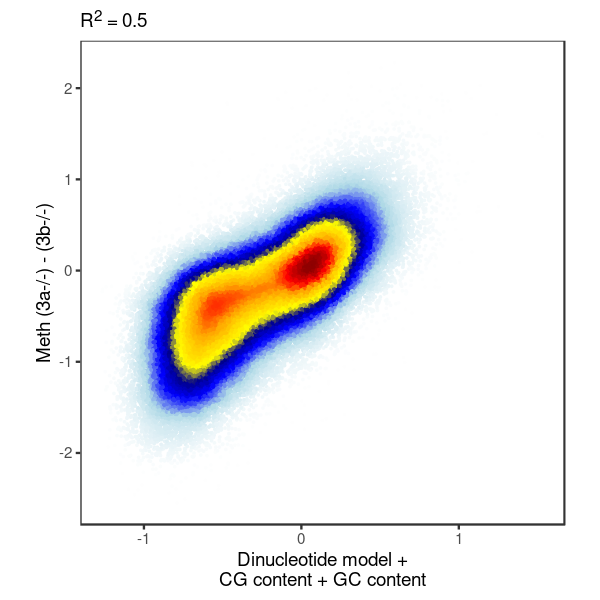

In [42]:
bandwidth <- 0.08
point_size <- 0.001
p_gc_cg <- plot_model_scatter(model_ab_gc_cg_xgb, x_lab="Dinucleotide model +\nCG content + GC content", y_lab = "Meth (3a-/-) - (3b-/-)")

options(repr.plot.width = 5, repr.plot.height=5)
p_gc_cg & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### Compute model with TOR

In [39]:
# model_ab_tor <- gen_seq_model(bind_cols(seq_df_wide, m_annot %>% select(tor)), m, dAB) %cache_rds% here("output/ab_dinuc_model_5bp_tor.rds")

model_ab_tor_xgb <- gen_seq_model_xgboost(bind_cols(seq_df_wide, m_annot %>% select(tor)), m, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_tor_xgboost.rds")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost.rds'



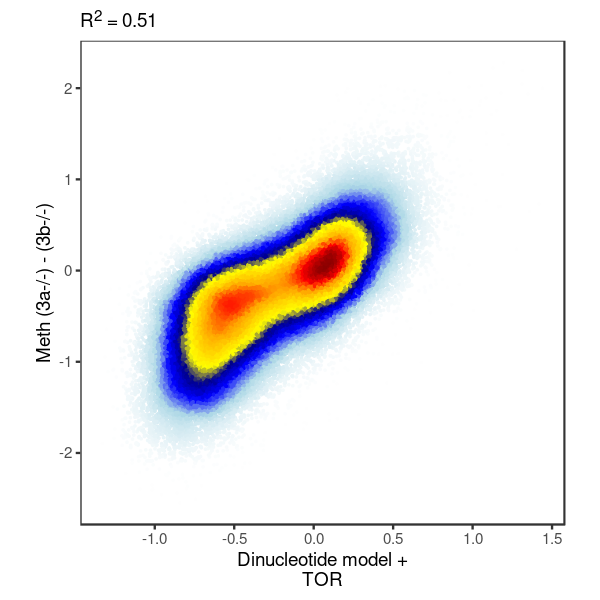

In [41]:
bandwidth <- 0.08
point_size <- 0.001
p_tor <- plot_model_scatter(model_ab_tor_xgb, x_lab="Dinucleotide model +\nTOR", y_lab = "Meth (3a-/-) - (3b-/-)")

options(repr.plot.width = 5, repr.plot.height=5)
p_tor & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

##### Test per day

In [44]:
m_days <- cpg_meth %>% 
    mutate(
        dAB_d0 = d0S_3a - d0S_3b,
        dAB_d1 = d1_3a - d1_3b,
        dAB_d2 = d2_3a - d2_3b,
        dAB_d3 = d3_3a - d3_3b,
        dAB_d4 = d4_3a - d4_3b    
    ) %>% 
    select(chrom:end, dAB_d0, dAB_d1, dAB_d2, dAB_d3, dAB_d4) %>% 
    right_join(m_annot %>% select(chrom, start, end, tor))

models_tor <- map(0:4, function(day){
    column <- glue("dAB_d{day}")
    print(column)
    f <- !is.na(m_days[[column]])
    print(sum(f))
    df <- bind_cols(seq_df_wide, m_days %>% select(tor)) %>% filter(f)    
    cur_m <- m_days %>% mutate(dAB = m_days[[column]]) %>% select(chrom, start, end, dAB) %>% filter(f)    
    model_ab_tor_xgb <- gen_seq_model_xgboost(df, cur_m, dAB, xgb_params) %cache_rds% here(glue("output/ab_dinuc_model_5bp_tor_xgboost_day{day}.rds"))
    return(model_ab_tor_xgb)
})


Joining, by = c("chrom", "start", "end")



dAB_d0
[1] 116103


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost_day0.rds'



dAB_d1
[1] 96888


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost_day1.rds'



dAB_d2
[1] 101899


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost_day2.rds'



dAB_d3
[1] 101693


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost_day3.rds'



dAB_d4
[1] 116115


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_tor_xgboost_day4.rds'



In [45]:
models <- map(0:4, function(day){
    column <- glue("dAB_d{day}")
    print(column)
    f <- !is.na(m_days[[column]])
    print(sum(f))
    df <- seq_df_wide %>% filter(f)    
    cur_m <- m_days %>% mutate(dAB = m_days[[column]]) %>% select(chrom, start, end, dAB) %>% filter(f)    
    model_ab_tor_xgb <- gen_seq_model_xgboost(df, cur_m, dAB, xgb_params) %cache_rds% here(glue("output/ab_dinuc_model_5bp_xgboost_day{day}.rds"))
    return(model_ab_tor_xgb)
})

dAB_d0
[1] 116103


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost_day0.rds'



dAB_d1
[1] 96888


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost_day1.rds'



dAB_d2
[1] 101899


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost_day2.rds'



dAB_d3
[1] 101693


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost_day3.rds'



dAB_d4
[1] 116115


Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_xgboost_day4.rds'



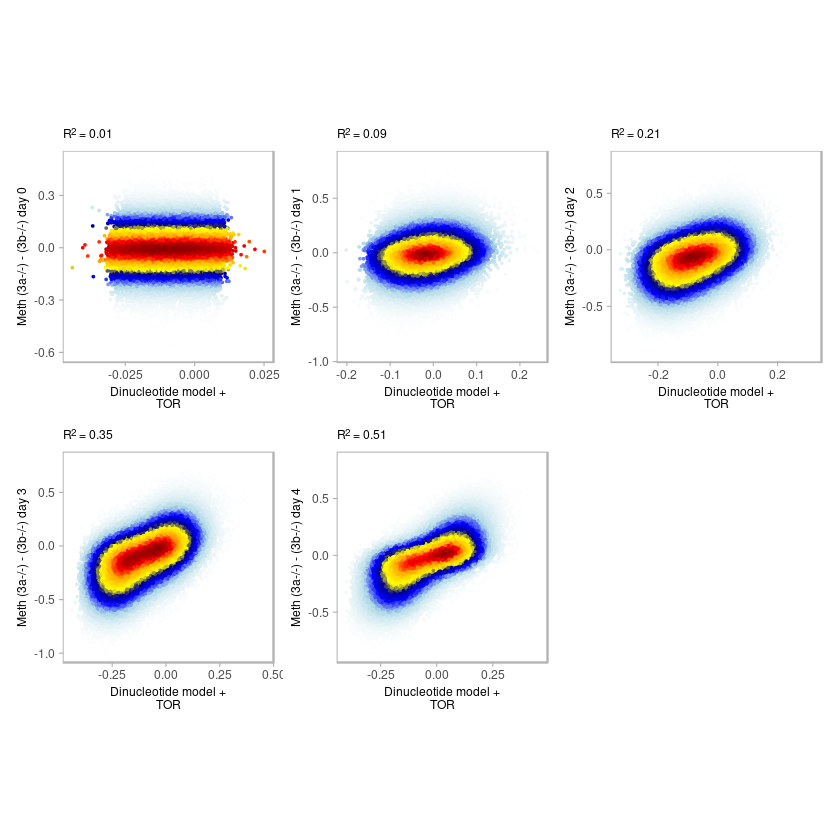

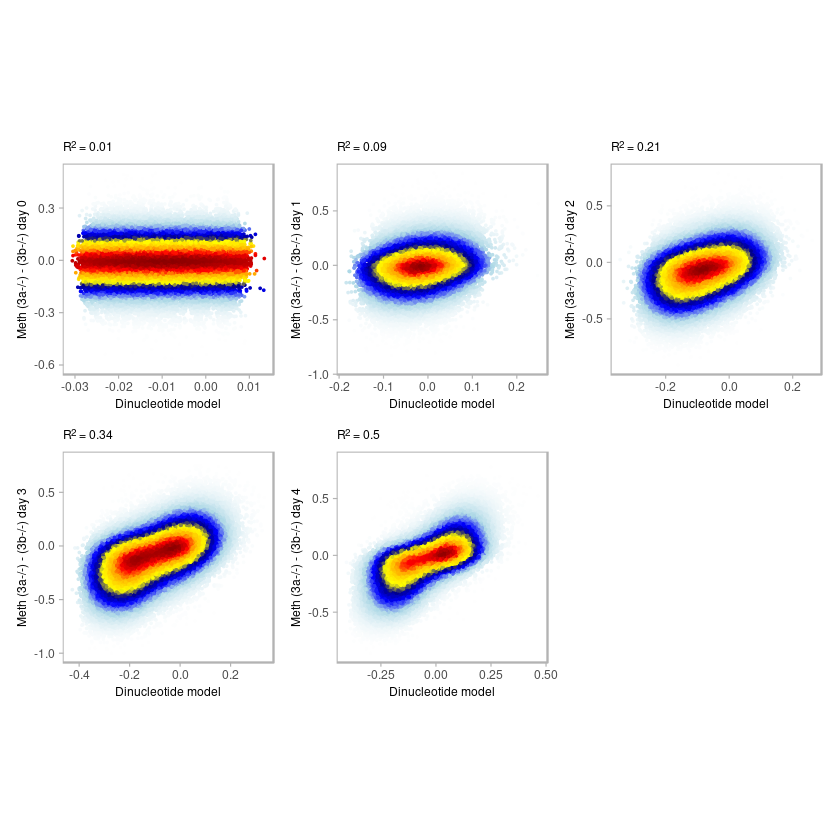

In [46]:
options(repr.plot.width = 7, repr.plot.height = 7)
bandwidth <- 0.08
point_size <- 0.001
plots_tor <- purrr::map2(models_tor, 0:4, ~
    plot_model_scatter(.x, x_lab="Dinucleotide model +\nTOR", y_lab = glue("Meth (3a-/-) - (3b-/-) day {.y}"))   
)

plots <- purrr::map2(models, 0:4, ~
    plot_model_scatter(.x, x_lab="Dinucleotide model", y_lab = glue("Meth (3a-/-) - (3b-/-) day {.y}"))      
)


wrap_plots(plots_tor)
wrap_plots(plots)

### Compute model with closest CpG

In [47]:
intervs_f <- m_annot %>% filter(!is.na(dAB_close)) %>% select(chrom, start, end, dAB_close)
m_f <- m %>% inner_join(intervs_f %>% select(chrom:end))
seq_df_wide_f <- seq_df_wide %>% inner_join(intervs_f)
model_ab_close_cg <- gen_seq_model(seq_df_wide_f, m_f, dAB) %cache_rds% here("output/ab_dinuc_model_5bp_close_cg.rds")
nrow(intervs_f)
model_ab_close_cg_xgb <- gen_seq_model_xgboost(seq_df_wide_f, m_f, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_close_cg_xgb.rds")
nrow(intervs_f)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_close_cg.rds'



[1] 80056

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_close_cg_xgb.rds'



[1] 80056

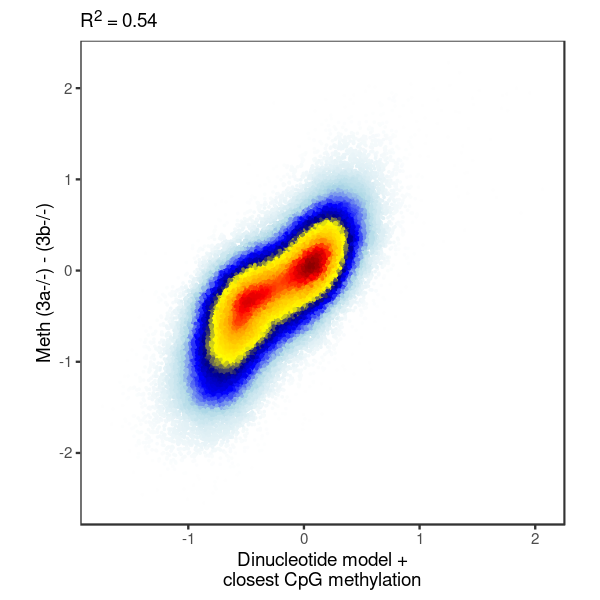

In [50]:
p_close_cg <- plot_model_scatter(model_ab_close_cg_xgb, x_lab="Dinucleotide model +\nclosest CpG methylation", y_lab = "Meth (3a-/-) - (3b-/-)")

options(repr.plot.width = 5, repr.plot.height=5)
p_close_cg & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### Compute model with all enhancer methylation

In [51]:
cpg_meth_meth_cov <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na = 5, rm_meth_cov=FALSE)

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day4_cpg_meth.tsv'



In [52]:
enh_intervs <- get_all_enhancers() %>% mutate(l = end - start) %>% filter(l <= 1e4) %>% select(-l)

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_germ_layers.csv'

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_encode.csv'



In [53]:
enh_intervs %>% mutate(l = end - start) %>% pull(l) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0    40.0   100.0   185.6   200.0  9980.0 

In [54]:
m_enh_punc <- cpg_meth_meth_cov %>% 
    gintervals.neighbors1(enh_intervs) %>% 
    filter(dist == 0) %>% 
    group_by(chrom1, start1, end1) %>% 
    mutate(mA_enh.meth = sum(d1_3a.meth, d2_3a.meth, d3_3a.meth, d4_3a.meth, na.rm=FALSE),
           mA_enh.cov = sum(d1_3a.cov, d2_3a.cov, d3_3a.cov, d4_3a.cov, na.rm=FALSE),
           mB_enh.meth = sum(d1_3b.meth, d2_3b.meth, d3_3b.meth, d4_3b.meth, na.rm=FALSE),
           mB_enh.cov = sum(d1_3b.cov, d2_3b.cov, d3_3b.cov, d4_3b.cov, na.rm=FALSE),
           
           mA.meth = psum(d1_3a.meth, d2_3a.meth, d3_3a.meth, d4_3a.meth, na.rm=FALSE),
           mA.cov = psum(d1_3a.cov, d2_3a.cov, d3_3a.cov, d4_3a.cov, na.rm=FALSE),
           mB.meth = psum(d1_3b.meth, d2_3b.meth, d3_3b.meth, d4_3b.meth, na.rm=FALSE),
           mB.cov = psum(d1_3b.cov, d2_3b.cov, d3_3b.cov, d4_3b.cov, na.rm=FALSE),
           
           mA_enh = (mA_enh.meth - mA.meth) / (mA_enh.cov - mA.cov),
           mB_enh = (mB_enh.meth - mB.meth) / (mB_enh.cov - mB.cov),
           dAB_enh = mA_enh - mB_enh
    ) %>% 
    ungroup() %>% 
    select(chrom, start, end, dAB_enh)

In [55]:
intervs_f <- m_annot %>% inner_join(m_enh_punc) %>% filter(!is.na(dAB_enh)) %>% select(chrom, start, end, dAB_enh)
m_f <- m %>% inner_join(intervs_f %>% select(chrom:end))
seq_df_wide_f <- seq_df_wide %>% inner_join(intervs_f)
model_ab_enh <- gen_seq_model(seq_df_wide_f, m_f, dAB) %cache_rds% here("output/ab_dinuc_model_5bp_enh_meth.rds")

model_ab_enh_xgb <- gen_seq_model_xgboost(seq_df_wide_f, m_f, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_enh_meth_xgb.rds")
nrow(intervs_f)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_enh_meth.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_enh_meth_xgb.rds'



[1] 45056

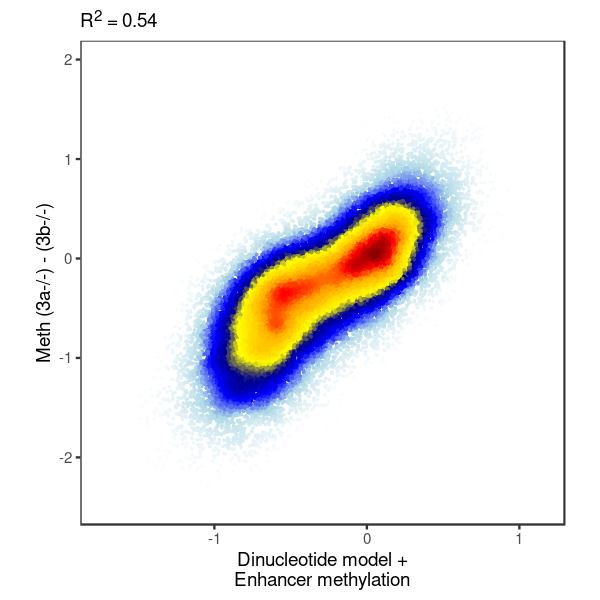

In [56]:
p_enh_meth <- plot_model_scatter(model_ab_enh_xgb, x_lab="Dinucleotide model +\nEnhancer methylation", y_lab = "Meth (3a-/-) - (3b-/-)")

options(repr.plot.width = 5, repr.plot.height=5)
p_enh_meth & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

#### All variables

In [57]:
intervs_f <- m_annot %>% inner_join(m_enh_punc) %>% filter(!is.na(dAB_enh)) %>% select(chrom, start, end, dAB_enh)
m_f <- m %>% inner_join(intervs_f %>% select(chrom:end))
seq_df_wide_f <- seq_df_wide %>% inner_join(intervs_f)
seq_df_wide_f <- seq_df_wide_f %>% left_join(m_annot %>% select(chrom:end, cg_cont, gc_cont, tor, dAB_close))
model_ab_all_vars_xgb <- gen_seq_model_xgboost(seq_df_wide_f, m_f, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_all_vars_xgb.rds")
nrow(intervs_f)

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Joining, by = c("chrom", "start", "end")

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_all_vars_xgb.rds'



[1] 45056

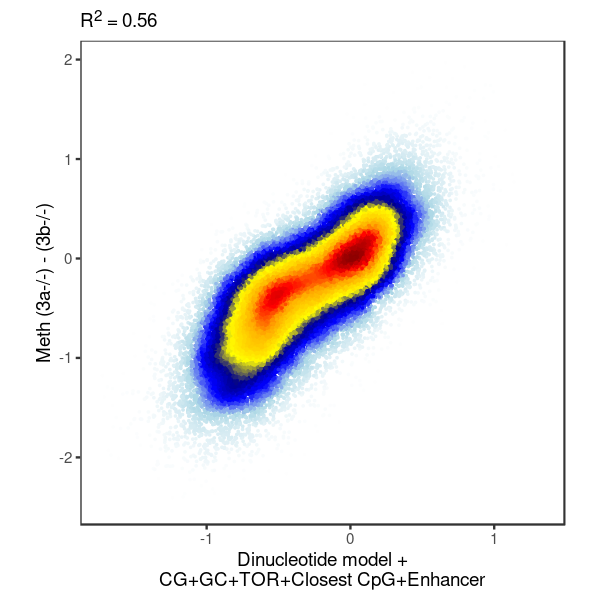

In [59]:
p_all_vars <- plot_model_scatter(model_ab_all_vars_xgb, x_lab="Dinucleotide model +\nCG+GC+TOR+Closest CpG+Enhancer", y_lab = "Meth (3a-/-) - (3b-/-)")

options(repr.plot.width = 5, repr.plot.height=5)
p_all_vars & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

In [60]:
tgppt::plot_gg_ppt(p_close_cg + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model1.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3, top = 9.7, overwrite=TRUE)
tgppt::plot_gg_ppt(p_gc_cg + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model1.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 5, top = 9.7)
tgppt::plot_gg_ppt(p_tor + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model1.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 5, top = 4)
tgppt::plot_gg_ppt(p_enh_meth + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model1.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 10, top = 9.7)
tgppt::plot_gg_ppt(p_all_vars + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(),, aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model1.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3 + 10, top = 4)

## Estimate prediction noise

In [61]:
cpg_meth1 <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na  = 5, rm_meth_cov=FALSE)
cpg_meth1 <- cpg_meth1 %>% inner_join(m %>% select(chrom, start, end))

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day4_cpg_meth.tsv'

Joining, by = c("chrom", "start", "end")



In [62]:
cpg_meth.avg <- cpg_meth1 %>% select(-ends_with("meth"), -ends_with("cov")) %>% intervs_to_mat()

cpg_meth.cov <- cpg_meth1 %>% select(chrom:end, ends_with("cov"))  %>% intervs_to_mat()
cpg_meth.cov <- cpg_meth.cov[, paste0(colnames(cpg_meth.avg), ".cov")]

# cpg_meth.meth <- cpg_meth1 %>% select(chrom:end, ends_with("meth")) %>% intervs_to_mat()
# cpg_meth.meth <- cpg_meth.meth[, paste0(colnames(cpg_meth.avg), ".meth")]

cpg_meth.samp_meth <- cpg_meth.avg
for (col in colnames(cpg_meth.avg)){
    suppressWarnings(cpg_meth.samp_meth[, col] <- map2_int(cpg_meth.cov[, paste0(col, ".cov")], cpg_meth.avg[, col], ~ sum(rbinom(n=.x, size=1, prob=.y) )))
}

cpg_meth.samp <- cpg_meth.samp_meth / cpg_meth.cov

In [63]:
m_samp <- cpg_meth.samp %>% mat_to_intervs() %>% 
    mutate(
        mA = psum(d1_3a, d2_3a, d3_3a, d4_3a, na.rm=FALSE),
        mB = psum(d1_3b, d2_3b, d3_3b, d4_3b, na.rm=FALSE),
        mwt = psum(d1_wt, d2_wt, d3_wt, d4_wt, na.rm=FALSE),
        dAB = mA - mB,
        dB = mB - mwt, 
        dA = mA - mwt    
    ) %>% 
    select(chrom, start, end, mA, mB, mwt, dAB, dB, dA) %>% 
    as_tibble()

In [64]:
message("dAB (dinuc)")
model_ab_samp <- gen_seq_model(seq_df_wide, m_samp, dAB) %cache_rds% here("output/ab_dinuc_model_5bp_samp.rds")
model_ab_samp_xgb <- gen_seq_model_xgboost(seq_df_wide, m_samp, dAB, xgb_params) %cache_rds% here("output/ab_dinuc_model_5bp_samp_xgboost.rds")

dAB (dinuc)

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_samp.rds'

Using cached rds from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/ab_dinuc_model_5bp_samp_xgboost.rds'



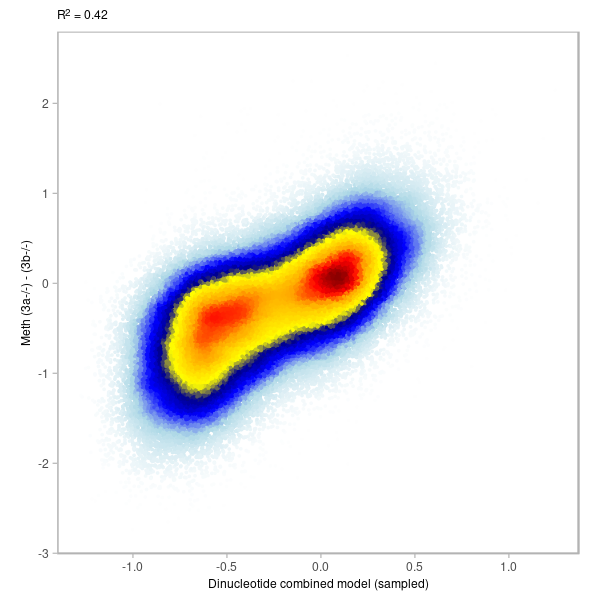

In [65]:
bandwidth <- 0.08
point_size <- 0.001
p_ab_samp <- plot_model_scatter(model_ab_samp_xgb, x_lab="Dinucleotide combined model (sampled)", y_lab = "Meth (3a-/-) - (3b-/-)")

p_ab_samp

[1] 0.98525

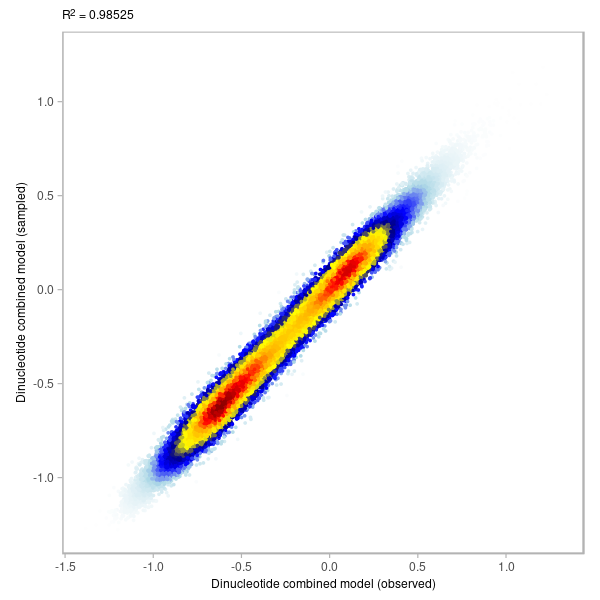

In [67]:
bandwidth <- 0.08
point_size <- 0.001
p_ab_samp_obs <- tibble(pred = model_ab_xgboost$pred, y = model_ab_samp_xgb$pred) %>% 
    mutate(col = densCols(., bandwidth=0.06,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=pred, y=y, col=col)) + 
        geom_point(shape=19, size=0.001) + 
        scale_color_identity() + 
#         coord_cartesian(xlim = c(-1.1, 0.6), ylim = c(-1.8, 1.2)) +                 
        xlab("Dinucleotide combined model (observed)") + 
        ylab("Dinucleotide combined model (sampled)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("R^2 = {cor}", cor = round(cor(model_ab_xgboost$pred, model_ab_samp_xgb$pred)^2, digits=5))) + 
        theme(plot.subtitle = ggtext::element_markdown())
p_ab_samp_obs
round(cor(model_ab_xgboost$pred, model_ab_samp_xgb$pred)^2, digits=5)

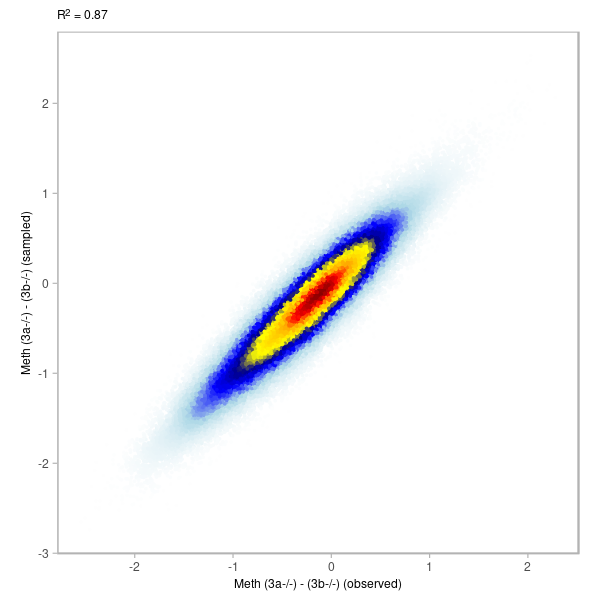

In [68]:
bandwidth <- 0.08
point_size <- 0.001
p_ab_samp_obs_y <- tibble(pred = model_ab_xgboost$y, y = model_ab_samp_xgb$y) %>% 
    mutate(col = densCols(., bandwidth=0.06,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=pred, y=y, col=col)) + 
        geom_point(shape=19, size=0.001) + 
        scale_color_identity() + 
#         coord_cartesian(xlim = c(-1.1, 0.6), ylim = c(-1.8, 1.2)) +                 
        xlab("Meth (3a-/-) - (3b-/-) (observed)") + 
        ylab("Meth (3a-/-) - (3b-/-) (sampled)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("R^2 = {cor}", cor = round(cor(model_ab_xgboost$y, model_ab_samp_xgb$y)^2, digits=2))) + 
        theme(plot.subtitle = ggtext::element_markdown())
p_ab_samp_obs_y

## Plot global EB trends

In [69]:
cpg_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na = 5)

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day4_cpg_meth.tsv'



In [70]:
cpg_meth <- gextract.left_join("seq.CG_500_mean", intervals=cpg_meth, iterator=cpg_meth, colnames="cg_cont") %>% select(-(chrom1:end1)) %>% select(chrom, start, end, cg_cont, everything()) %>% as_tibble()

In [71]:
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange", "tko" = "darkgray")
df <- cpg_meth %>% 
    mutate(cg_cont = cut(cg_cont, c(0,0.03,0.08,0.15), include.lowest=TRUE, labels=c("low", "mid", "high"))) %>% 
    group_by(cg_cont) %>% 
    summarise_at(vars(starts_with("d")), mean, na.rm=TRUE) %>% 
    gather("samp", "meth", -cg_cont) %>% 
    separate(samp, c("day", "line"), sep="_") %>% 
    filter(day != "d0S") %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(line = factor(line, levels = names(line_colors)))

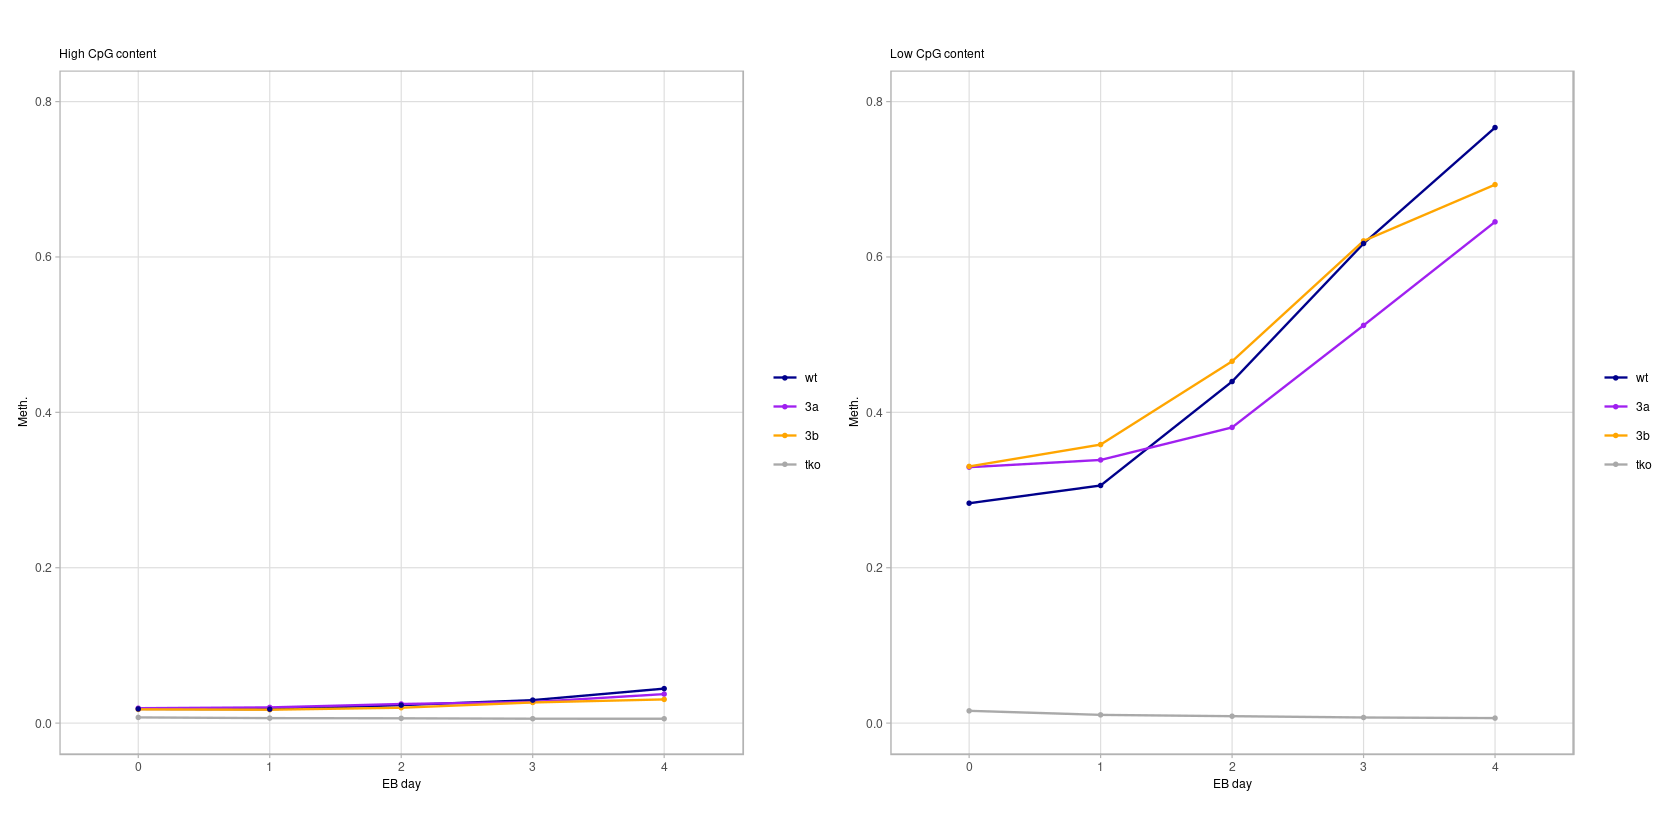

In [72]:
options(repr.plot.width = 14, repr.plot.height = 7)
p_high <- df %>% filter(cg_cont == "high") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("High CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_low <- df %>% filter(cg_cont == "low") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("Low CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_high + p_low

In [73]:
tgppt::plot_gg_ppt(p_high + theme_arial(7) + guides(color=FALSE), here("figures/eb_global_trends.pptx"), width = 3, height = 3, left = 1.3, top = 9.7, overwrite=TRUE)
tgppt::plot_gg_ppt(p_low + theme_arial(7), here("figures/eb_global_trends.pptx"), width = 3, height = 3, left = 1.3 + 3, top = 9.7, sep_legend = TRUE)

Same for X chromosome

In [74]:
line_colors <- c("wt" = "darkblue", "3a" = "purple", "3b" = "orange", "tko" = "darkgray")
df <- cpg_meth %>% 
    mutate(type = case_when(chrom == "chrX" ~ "X", TRUE ~ "autosome")) %>% 
    mutate(cg_cont = cut(cg_cont, c(0,0.03,0.08,0.15), include.lowest=TRUE, labels=c("low", "mid", "high"))) %>% 
    group_by(type, cg_cont) %>% 
    summarise_at(vars(starts_with("d")), mean, na.rm=TRUE) %>% 
    gather("samp", "meth", -cg_cont, -type) %>% 
    separate(samp, c("day", "line"), sep="_") %>% 
    filter(day != "d0S") %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(line = factor(line, levels = names(line_colors)))

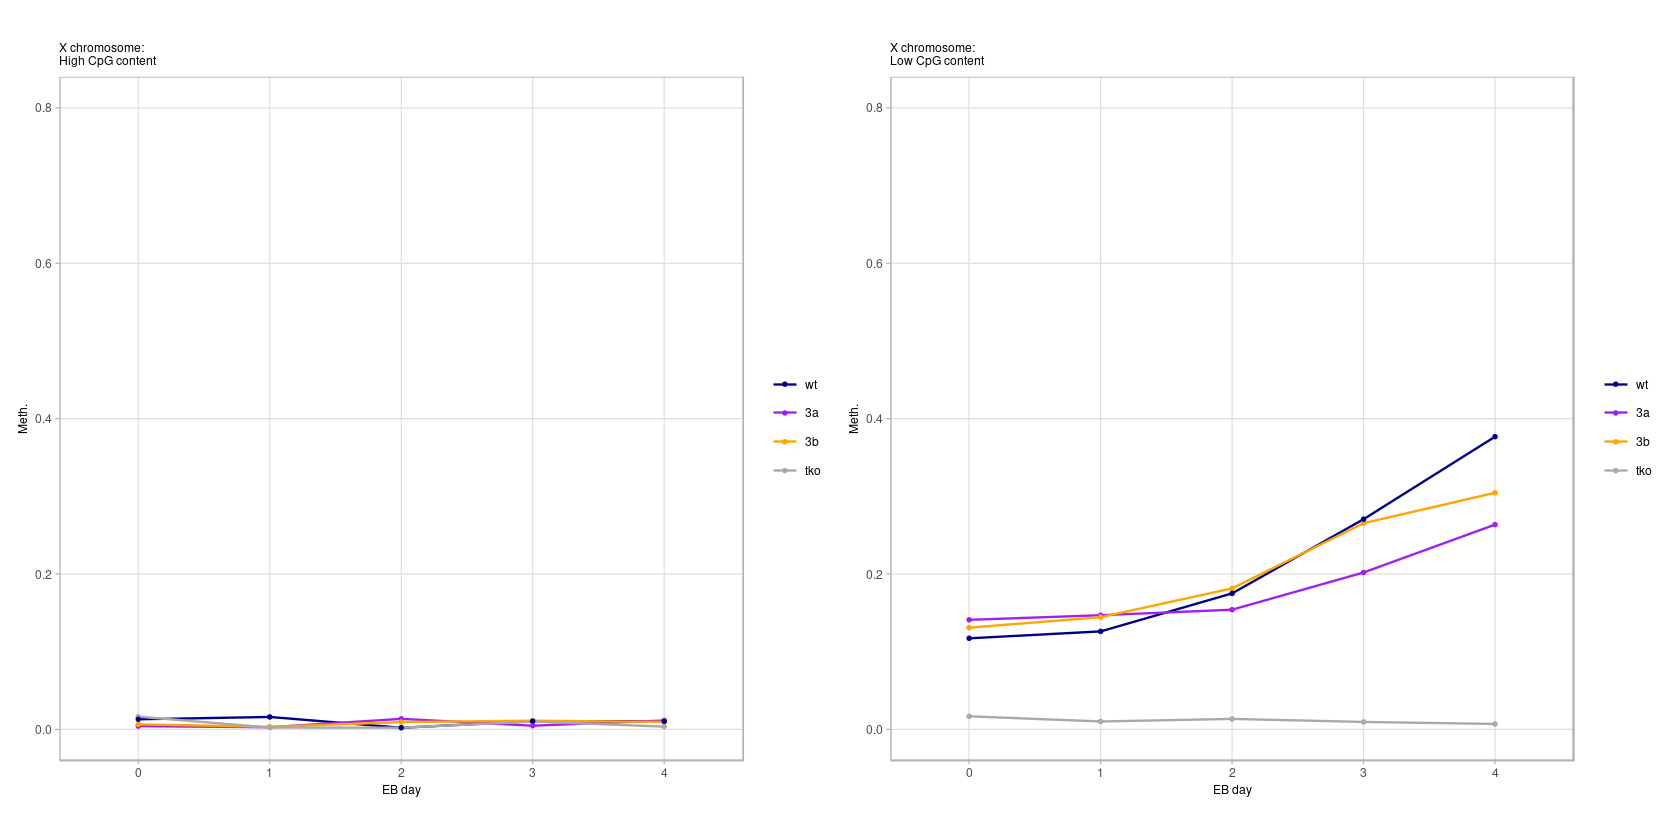

In [76]:
options(repr.plot.width = 14, repr.plot.height = 7)
p_high_x <- df %>% filter(type == "X", cg_cont == "high") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("X chromosome:\nHigh CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_low_x <- df %>% filter(type == "X", cg_cont == "low") %>% ggplot(aes(x=day, y=meth, color=line, group=line)) + geom_line() + geom_point(size=0.5) + ggtitle("X chromosome:\nLow CpG content") + xlab("EB day") + ylab("Meth.") + theme(aspect.ratio = 1) + scale_color_manual(name = "", values = line_colors) + scale_y_continuous(limits=c(0,0.8))
p_high_x + p_low_x

In [77]:
tgppt::plot_gg_ppt(p_high_x + theme_arial(7) + guides(color=FALSE), here("figures/eb_global_trends_chrX.pptx"), width = 3, height = 3, left = 1.3, top = 9.7, overwrite=TRUE)
tgppt::plot_gg_ppt(p_low_x + theme_arial(7), here("figures/eb_global_trends_chrX.pptx"), width = 3, height = 3, left = 1.3 + 3, top = 9.7, sep_legend = TRUE)

#### Distribution of A-B methylation Single CpG Density per day

In [110]:
df <- cpg_meth %>% select(chrom, start, end)
for (d in 0:4){
    df[[paste0("d", d)]] <- cpg_meth[[glue("d{d}_3a")]] - cpg_meth[[glue("d{d}_3b")]]
}
df <- df %>% gather("day", "diff", -(chrom:end)) %>% mutate(day = gsub("d", "Day ", day))

Picking joint bandwidth of 0.00905

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.0133

Picking joint bandwidth of 0.0161

Picking joint bandwidth of 0.0115



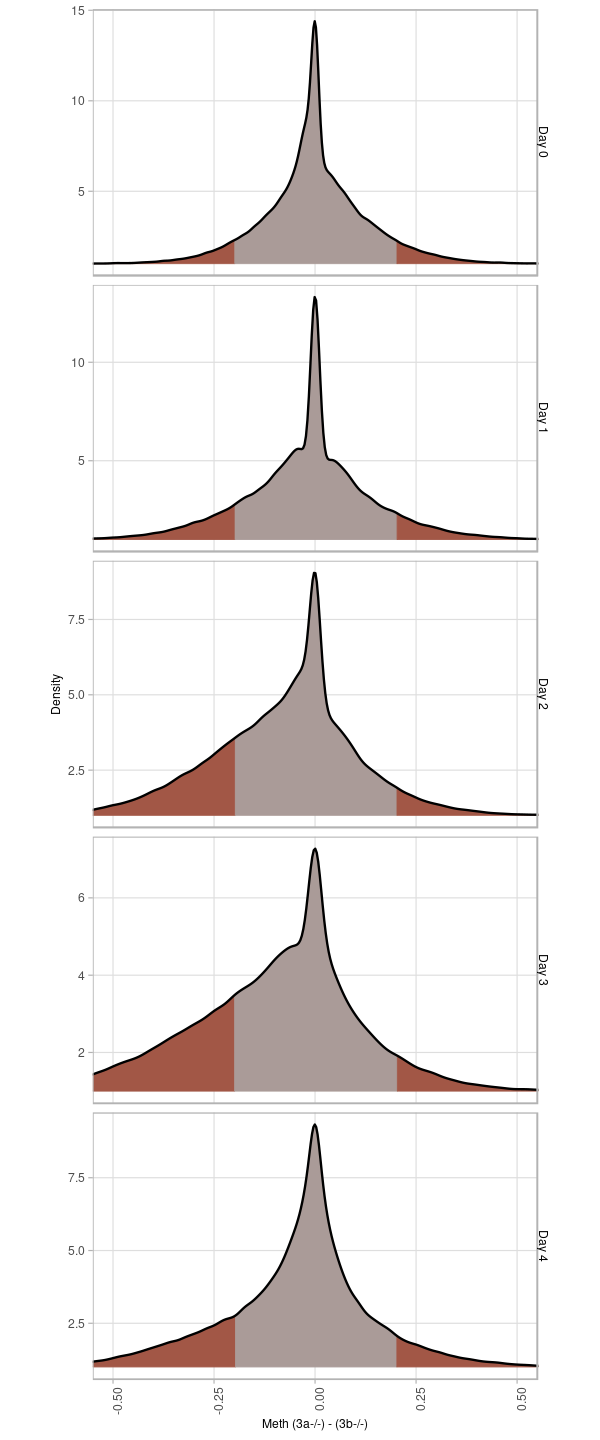

In [111]:
options(repr.plot.width=5, repr.plot.height=12)
p <- df %>%     
    ggplot(aes(x=diff, fill=stat(abs(x)), y=1)) + 
        ggridges::geom_density_ridges_gradient(lwd = 0.5) + 
#         scale_fill_viridis_c(option = "A", begin = 0.1) + 
        scale_fill_stepsn(colors=c("darkgray", "darkred"), breaks = c(0, 0.2, 1)) + 
        guides(fill=FALSE) + 
        ylab("Density") + 
        xlab("Meth (3a-/-) - (3b-/-)") + 
        coord_cartesian(xlim = c(-0.5, 0.5)) + 
        facet_grid(day~., scales="free_y") + 
        theme_arial(7) + 
        theme(aspect.ratio=0.6) + 
        vertical_labs()
p

In [112]:
file.remove(here("figures/eb_global_trends1.pptx"))
tgppt::plot_gg_ppt(p, here("figures/eb_global_trends1.pptx"), width = 4, height = 6.5, left = 1.3, top = 9.7 - 5)

[1] TRUE

Picking joint bandwidth of 0.00905

Picking joint bandwidth of 0.011

Picking joint bandwidth of 0.0133

Picking joint bandwidth of 0.0161

Picking joint bandwidth of 0.0115



### Kinteics per time and score bin

In [113]:
track_df <- tracks_key %>% filter(day %in% c("d0S", paste0("d", 0:6)))  %>% group_by(day, line) %>% mutate(name1 = glue("{day}_{line}_{sort}_{1:n()}")) %>% ungroup()  %>% select(line, day, sort, name = name1, track_name) %>% unite("grp", day, line, sort, remove=FALSE)

cpg_meth_all <- gextract_meth(
    tracks = track_df$track_name, 
    names=track_df$name, 
    intervals=gintervals.union("intervs.captPBAT_probes.ES_EB_V1", "intervs.captPBAT_probes.ES_EB_V2"), 
    extract_meth_calls = TRUE) %cache_df% here("output/eb_day0_to_day6_cpg_meth.tsv")  %>% select(-intervalID) %>% as_tibble()    

cpg_meth_all <- cpg_meth_all %>% select(-ends_with("ko1"))  
colnames(cpg_meth_all) <- gsub("ko3a", "3a", colnames(cpg_meth_all))
colnames(cpg_meth_all) <- gsub("ko3b", "3b", colnames(cpg_meth_all))

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day6_cpg_meth.tsv'



In [114]:
cpg_meth_days <- cpg_meth_all %>% select(chrom, start, end)
grps <- expand.grid(paste0("d", 0:6), c("wt", "3a", "3b")) %>% unite("var", c("Var1", "Var2")) %>% pull(var)
for (g in grps){
    cov_cols <- grep(glue("{g}.*cov$"), colnames(cpg_meth_all), value=TRUE)
    meth_cols <- grep(glue("{g}.*meth$"), colnames(cpg_meth_all), value=TRUE)
    cpg_meth_days[[paste0(g, ".cov")]] <- rowSums(cpg_meth_all[, cov_cols], na.rm=TRUE)
    cpg_meth_days[[paste0(g, ".meth")]] <- rowSums(cpg_meth_all[, meth_cols], na.rm=TRUE)
}

In [115]:
cpg_intervs <- cpg_meth_all %>% select(chrom:end)
scores_df <- gextract("DNMT.ab_score_xgb_plus", iterator=cpg_intervs, intervals=cpg_intervs, colnames="ab_score") %>% arrange(intervalID) %>% select(-intervalID) %>% as_tibble()

In [116]:
cov_mat <- cpg_meth_days %>% select(chrom:end, ends_with("cov")) %>% intervs_to_mat()
colnames(cov_mat) <- gsub(".cov$", "", colnames(cov_mat))
meth_mat <- cpg_meth_days %>% select(chrom:end, ends_with("meth")) %>% intervs_to_mat()
colnames(meth_mat) <- gsub(".meth$", "", colnames(meth_mat))

In [117]:
score_qs <- quantile(scores_df$ab_score, (0:20)/20)
score_qs[length(score_qs)] <- score_qs[length(score_qs)]+1
score_qs[1] <- score_qs[1]-1
scores_df <- scores_df %>% mutate(score_grp = as.character(as.numeric(cut(ab_score, breaks=score_qs, include.lowest = TRUE))))

In [118]:
cov_bin <- tgs_matrix_tapply(t(cov_mat), scores_df$score_grp, sum, na.rm=TRUE)
meth_bin <- tgs_matrix_tapply(t(meth_mat), scores_df$score_grp, sum, na.rm=TRUE)
stopifnot(all(colnames(cov_bin) == colnames(meth_bin)))
avg_bin <- meth_bin / cov_bin
avg_df <- avg_bin %>% as.data.frame() %>% rownames_to_column("bin") %>% gather("samp", "val", -bin) %>% separate(samp, c("day", "line")) %>% as_tibble()

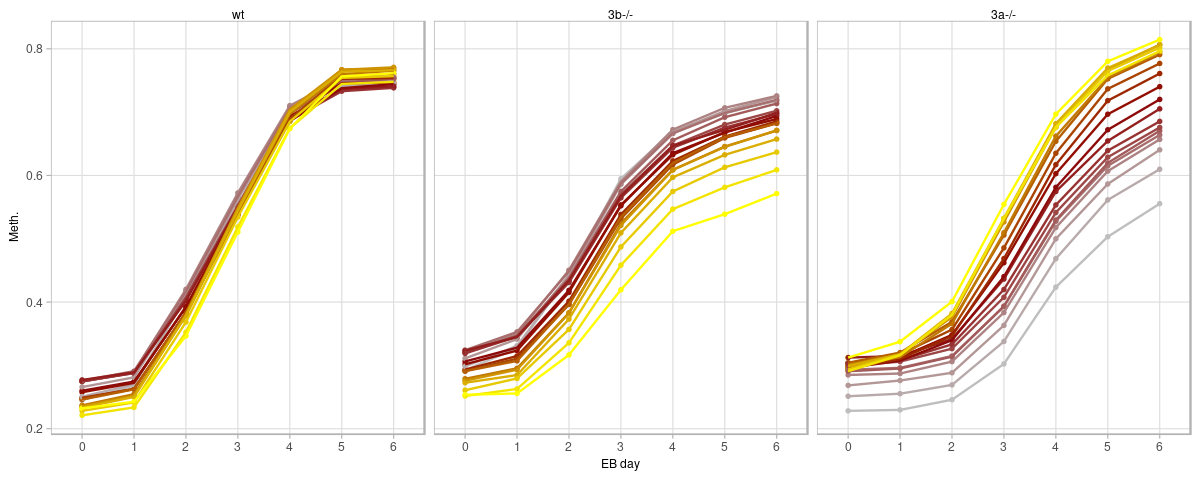

In [119]:
options(repr.plot.width = 10, repr.plot.height=4)
cols <- colorRampPalette(c("gray", "darkred","yellow"))(20)
p <- avg_df %>% 
    mutate(day = gsub("d", "", day)) %>% 
    mutate(bin = factor(bin, levels=as.character(1:20))) %>%
    mutate(line = factor(line, levels=c("wt", "3b", "3a"))) %>%
    mutate(line = fct_recode(line, "3b-/-" = "3b", "3a-/-" = "3a")) %>%
    ggplot(aes(x=day, y=val, color=bin, group=bin)) + 
        geom_point(size=0.5) + 
        geom_line(lwd = 0.5) + 
        scale_color_manual(values=cols) + 
        facet_grid(.~line) + 
        xlab("EB day") + 
        ylab("Meth.") + 
        guides(color=FALSE) + 
        theme_arial(7)  
#         theme(aspect.ratio = 0.7)
p

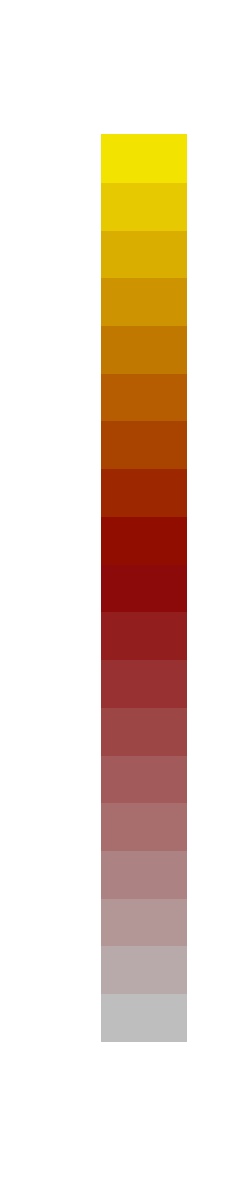

In [120]:
options(repr.plot.width=2, repr.plot.height=10)
color.bar <- function(lut, min, max=-min, nticks=11, ticks=seq(min, max, len=nticks), title='') {
    scale = (length(lut)-1)/(max-min)

    plot(c(0,10), c(min,max), type='n', bty='n', xaxt='n', xlab='', yaxt='n', ylab='', main=title)
#     axis(2, ticks, las=1)
    for (i in 1:(length(lut)-1)) {
     y = (i-1)/scale + min
     rect(0,y,10,y+1/scale, col=lut[i], border=NA)
    }
}
color.bar(cols, min=1, max=20, nticks=20)

In [121]:
tgppt::plot_gg_ppt(p, here("figures/eb_score_kinetics.pptx"), width = 10, height = 3.5, left = 1.3, top = 9.7 - 5, overwrite=TRUE)

### Scores within enhancers

In [54]:
enh_intervs <- get_all_enhancers()

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_germ_layers.csv'

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_encode.csv'



In [55]:
small_enh <- enh_intervs %>% mutate(l = end - start) %>% filter(l <= 1e4)

In [56]:
enh_cpg_score <- gextract.left_join("DNMT.ab_score_xgb_plus", intervals = small_enh, iterator = "intervs.global.seq_CG", colnames="score") %>% as_tibble()

#### Plot distribution of sequence scores inside enhancers

In [57]:
enh_cpg_score <- enh_cpg_score %>% add_count(chrom1, start1, end1, name = "n_cpgs")

In [58]:
mean_enh_score <- enh_cpg_score %>% group_by(chrom1, start1, end1, n_cpgs) %>% summarise(mean_enh = mean(score), .groups="drop")

In [59]:
enh_cpg_score_shuff <- enh_cpg_score %>% mutate(score = sample(score))
mean_enh_score_shuff <- enh_cpg_score_shuff %>% group_by(chrom1, start1, end1, n_cpgs) %>% summarise(mean_enh = mean(score), .groups="drop")

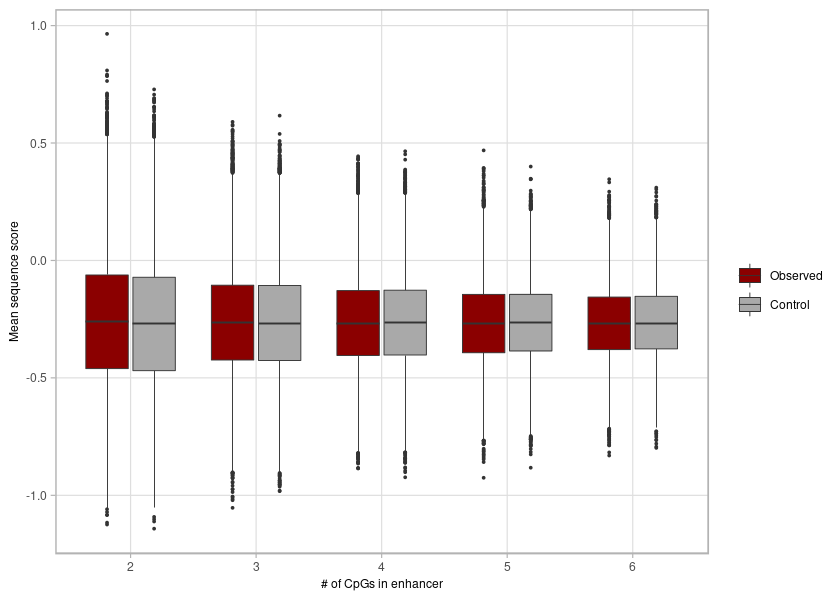

In [60]:
options(repr.plot.width = 7, repr.plot.height = 5)
p <- bind_rows(mean_enh_score %>% mutate(type = "Observed"), mean_enh_score_shuff %>% mutate(type = "Control")) %>% filter(n_cpgs %in% c(2:6)) %>% mutate(type = factor(type, levels = c("Observed", "Control"))) %>% ggplot(aes(x=factor(n_cpgs), y=mean_enh, fill=type)) + geom_boxplot( outlier.size = 0.005, lwd = 0.2) + scale_fill_manual(name="", values=c("Observed" = "darkred", "Control" = "darkgray")) + xlab("# of CpGs in enhancer") + ylab("Mean sequence score")
p

In [61]:
tgppt::plot_gg_ppt(p + guides(fill=FALSE), here("figures/mean_enh_score.pptx"), width = 5, height = 4, left = 1.3, top = 9.7 - 5, rasterize_plot = TRUE, overwrite=TRUE)

### No difference in methylation of full enhancers vs shuffled

In [70]:
enh_cpg_score1 <- enh_cpg_score %>% mutate(center = start1 + (end1 - start1) / 2, d_center = abs(start - center))  %>% group_by(chrom1, start1, end1) %>% filter(n() >= 5) %>% arrange(chrom1, start1, end1, d_center) %>% dplyr::slice(1:5) %>% ungroup()

In [71]:
set.seed(17)
obs_df <- enh_cpg_score1 %>% group_by(chrom1, start1, end1) %>% summarise(mean_score = mean(score, na.rm=TRUE), .groups="drop") %>% mutate(type = "obs")
shuff_df <- enh_cpg_score1 %>% mutate(score = sample(score)) %>% group_by(chrom1, start1, end1) %>% summarise(mean_score = mean(score, na.rm=TRUE), .groups="drop") %>% mutate(type = "shuff")

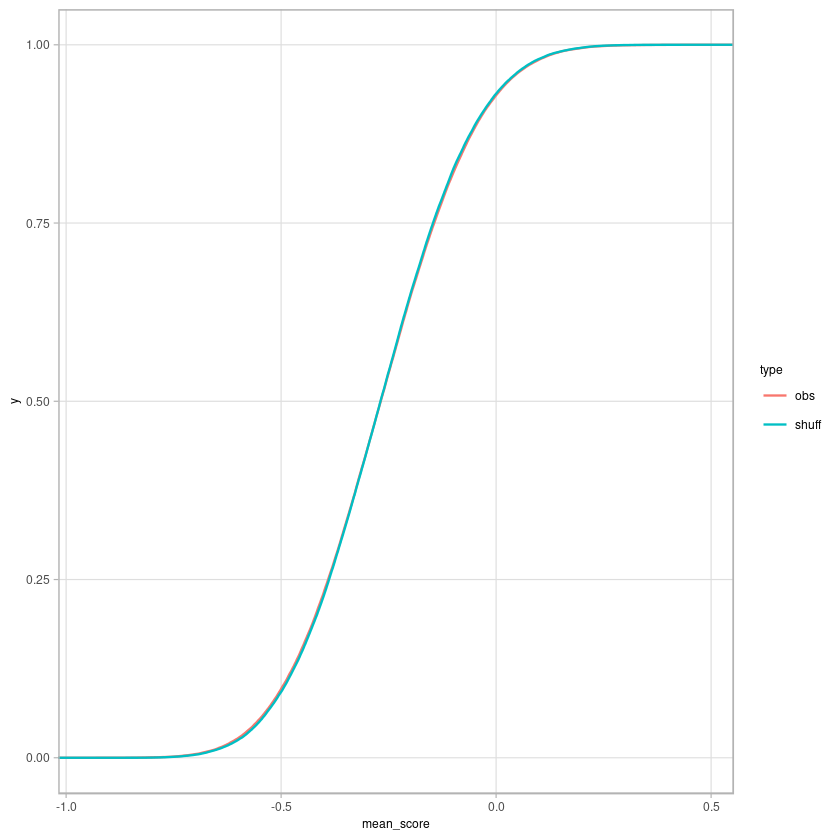

In [72]:
options(repr.plot.width = 7, repr.plot.height = 7)
bind_rows(shuff_df, obs_df) %>% ggplot(aes(x=mean_score, color=type)) + stat_ecdf()

In [73]:
ks.test(shuff_df$mean_score, obs_df$mean_score)

Warning message in ks.test(shuff_df$mean_score, obs_df$mean_score):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  shuff_df$mean_score and obs_df$mean_score
D = 0.0054998, p-value = 0.07177
alternative hypothesis: two-sided


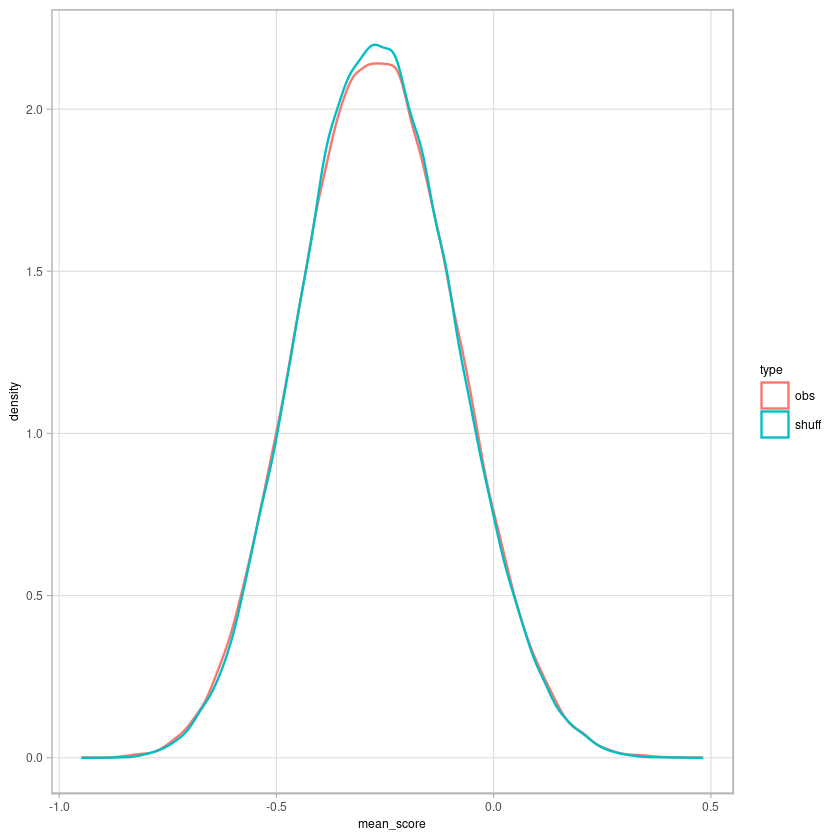

In [74]:
bind_rows(shuff_df, obs_df) %>% ggplot(aes(x=mean_score, color=type)) + geom_density()

In [75]:
map_dfr(c(-0.5, -0.3, -0.2), function(thresh) tibble(thresh = thresh, fdr = (obs_df %>% filter(mean_score <= thresh) %>% nrow()) / (shuff_df %>% filter(mean_score <= thresh) %>% nrow())))

thresh,fdr
<dbl>,<dbl>
-0.5,1.0451276
-0.3,1.0012640
-0.2,0.9950387


### Toatal enh methylation prediction

In [76]:
enh_intervs <- get_all_enhancers()
small_enh <- enh_intervs %>% mutate(l = end - start) %>% filter(l <= 1e4)
full_enh_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na = 5, intervals=small_enh, iterator = small_enh, cache_fn = here("output/eb_day0_to_day4_full_enh_meth.tsv"))

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_germ_layers.csv'

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/enh_intervs_encode.csv'

Using cached dataframe from '/net/mraid14/export/tgdata/users/aviezerl/proj/ebdnmt/output/eb_day0_to_day4_full_enh_meth.tsv'



In [77]:
# cpg_enh_meth <- calc_eb_day0_to_day4_cpg_meth(min_cov = 10, max_na = 5, intervals=small_enh, cache_fn = here("output/eb_day0_to_day4_cpg_enh_meth.tsv"))

In [78]:
m_full <- full_enh_meth %>% 
    mutate(
        mA = psum(d1_3a, d2_3a, d3_3a, d4_3a, na.rm=FALSE),
        mB = psum(d1_3b, d2_3b, d3_3b, d4_3b, na.rm=FALSE),
        mwt = psum(d1_wt, d2_wt, d3_wt, d4_wt, na.rm=FALSE),
        dAB = mA - mB,
        dB = mB - mwt, 
        dA = mA - mwt    
    ) %>% 
    select(chrom, start, end, mA, mB, mwt, dAB, dB, dA)

In [79]:
locus_means <- rowMeans(full_enh_meth %>% select(-(chrom:end)), na.rm=TRUE)
locus_sds <- matrixStats::rowSds(full_enh_meth %>% select(-(chrom:end)) %>% as.matrix(), na.rm=TRUE)

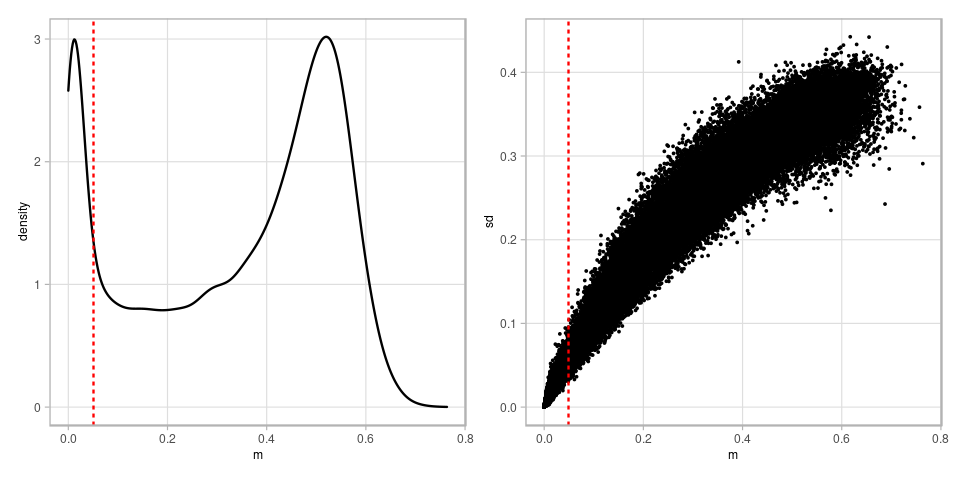

In [80]:
options(repr.plot.width = 8, repr.plot.height = 4)
thresh <- 0.05
p1 <- tibble(m = locus_means) %>% ggplot(aes(x=m)) + geom_density() + geom_vline(xintercept=thresh, linetype="dashed", color="red")
p2 <- tibble(m = locus_means, sd = locus_sds) %>% ggplot(aes(x=m, y=sd)) + geom_point(size=0.01) + geom_vline(xintercept=thresh, linetype="dashed", color="red")
p1 + p2

In [81]:
m_full <- m_full[locus_means >= thresh, ]

In [82]:
sum(locus_means < thresh)
nrow(m)

[1] 11189

[1] 116117

In [83]:
m_full_dAB <- m_full %>% filter(!is.na(dAB)) %>% select(chrom, start, end, dAB)
m_full_cpg_scores <- gextract.left_join("DNMT.ab_score_xgb_plus", intervals = m_full_dAB, iterator = "intervs.global.seq_CG", colnames="score") %>% as_tibble()

In [84]:
m_full_pred <- m_full_cpg_scores %>% group_by(chrom1, start1, end1) %>% filter(n() >= 2) %>% summarise(score = mean(score), dAB = dAB[1], .groups="drop") %>% rename(chrom = chrom1, start = start1, end = end1, pred = score, y = dAB) %>% filter(!is.na(pred), !is.na(y))

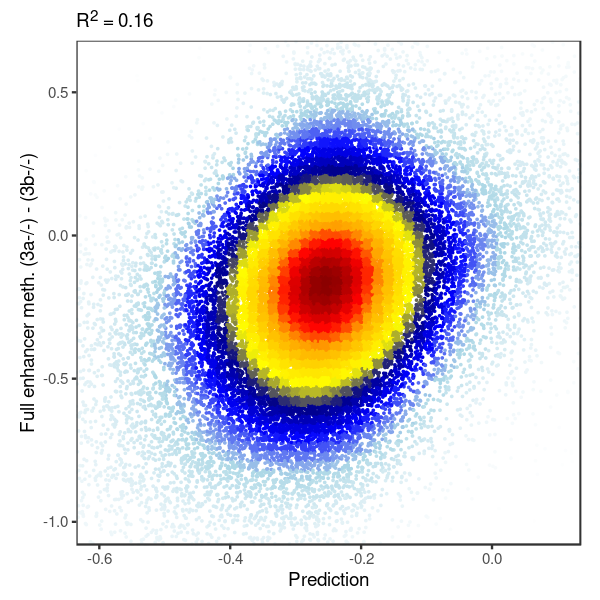

In [85]:
bandwidth <- 0.08
point_size <- 0.001
# point_size <- 0.1
p_full_enh_meth <- tibble(pred = m_full_pred$pred, y = m_full_pred$y) %>%     
    mutate(col = densCols(., bandwidth=bandwidth,colramp=colorRampPalette(c("white","lightblue", "blue", "darkblue", "yellow", "gold","orange","red", "darkred" )))) %>% 
    ggplot(aes(x=pred, y=y, col=col)) + 
        geom_point(shape=19, size=point_size) + 
        scale_color_identity() + 
        coord_cartesian(xlim = c(-0.6, 0.1), ylim = c(-1, 0.6)) +                 
        xlab("Prediction") + 
        ylab("Full enhancer meth. (3a-/-) - (3b-/-)") +         
        theme(aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + 
        labs(subtitle = glue("R^2 = {cor}", cor = round(cor(m_full_pred$pred, m_full_pred$y)^2, digits=2)))

options(repr.plot.width = 5, repr.plot.height=5)
p_full_enh_meth & theme_bw() & theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank())

In [86]:
tgppt::plot_gg_ppt(p_full_enh_meth + theme_arial(7) + theme(plot.subtitle = ggtext::element_markdown(), aspect.ratio=1, panel.grid.major=element_blank(), panel.grid.minor=element_blank()), here("figures/model2.pptx"), rasterize_plot=TRUE, width = 4, height = 4, left = 1.3, top = 9.7, overwrite=TRUE)

In [87]:
m_full_pred_cg_num <- m_full_cpg_scores %>% group_by(chrom1, start1, end1) %>% mutate(n_cpgs = n()) %>% group_by(chrom1, start1, end1, n_cpgs) %>% summarise(score = mean(score), dAB = dAB[1], .groups="drop") %>% rename(chrom = chrom1, start = start1, end = end1, pred = score, y = dAB) %>% filter(!is.na(pred),  !is.na(y)) %>% group_by(n_cpgs) %>% summarise(rsq = cor(pred, y)^2)

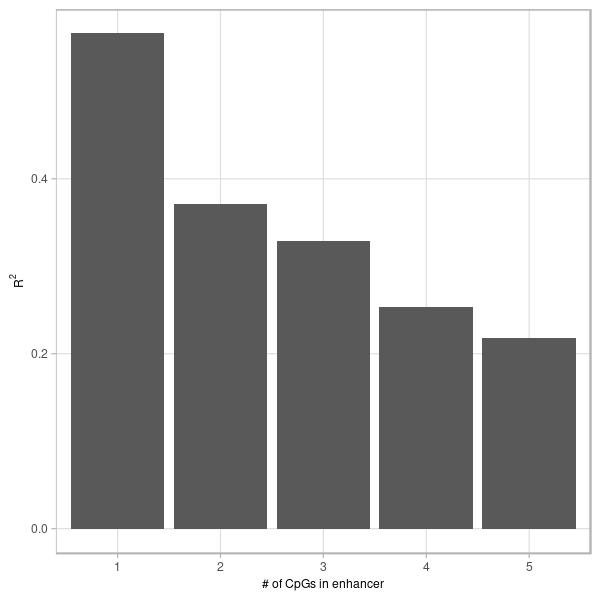

In [88]:
p <- m_full_pred_cg_num %>% filter(n_cpgs >= 1, n_cpgs <= 5) %>% ggplot(aes(x=factor(n_cpgs), y=rsq)) + geom_col() + xlab("# of CpGs in enhancer") + ylab(expression (R^2))
p

tgppt::plot_gg_ppt(p + theme_arial(7), here("figures/model2.pptx"), rasterize_plot=FALSE, width = 5, height = 4, left = 1.3 + 5, top = 9.7)

In [89]:
df_full <- full_enh_meth %>% select(chrom, start, end)
for (d in 0:4){
    df_full[[paste0("d", d)]] <- full_enh_meth[[glue("d{d}_3a")]] - full_enh_meth[[glue("d{d}_3b")]]
}
df_full <- df_full %>% gather("day", "diff", -(chrom:end)) %>% mutate(day = gsub("d", "Day ", day))

Picking joint bandwidth of 0.00826

Picking joint bandwidth of 0.00977

Picking joint bandwidth of 0.0116

Picking joint bandwidth of 0.0129

Picking joint bandwidth of 0.00574



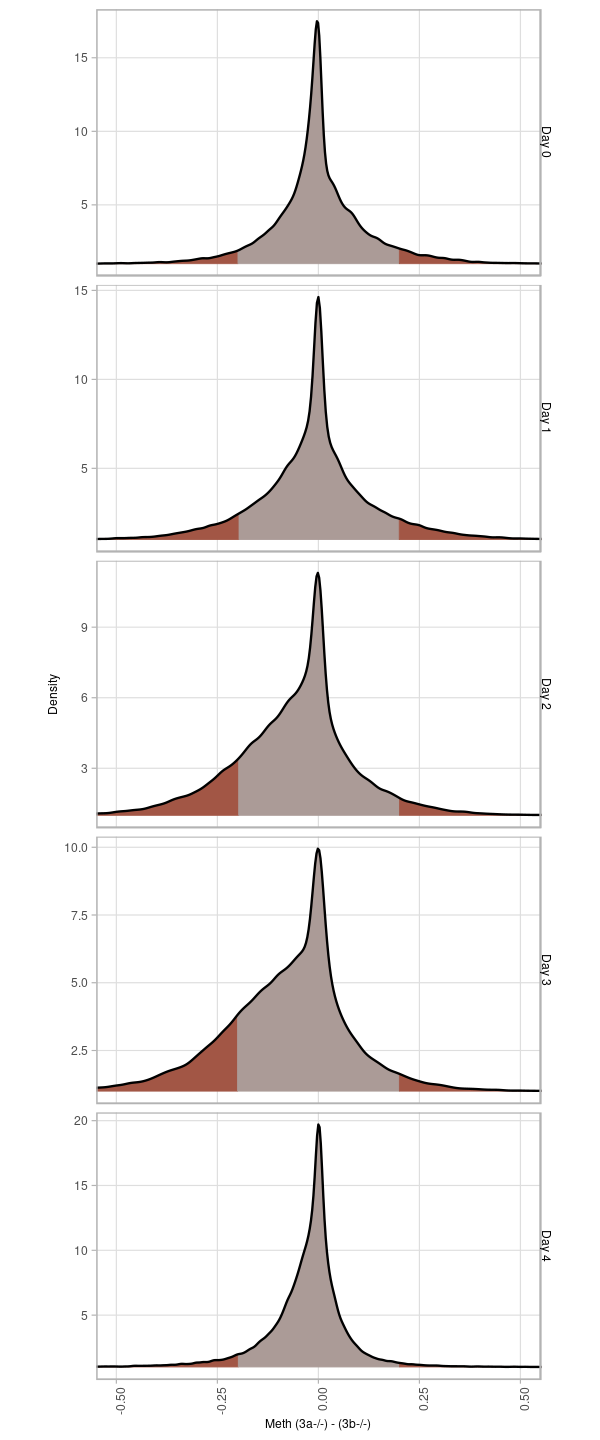

In [90]:
options(repr.plot.width=5, repr.plot.height=12)
p <- df_full %>%     
    ggplot(aes(x=diff, fill=stat(abs(x)), y=1)) + 
        ggridges::geom_density_ridges_gradient(lwd = 0.5) + 
#         scale_fill_viridis_c(option = "A", begin = 0.1) + 
        scale_fill_stepsn(colors=c("darkgray", "darkred"), breaks = c(0, 0.2, 1)) + 
        guides(fill=FALSE) + 
        ylab("Density") + 
        xlab("Meth (3a-/-) - (3b-/-)") + 
        coord_cartesian(xlim = c(-0.5, 0.5)) + 
        facet_grid(day~., scales="free_y") + 
        theme_arial(7) + 
        theme(aspect.ratio=0.6) + 
        vertical_labs()
p

In [91]:
tgppt::plot_gg_ppt(p, here("figures/eb_global_trends1.pptx"), width = 4, height = 6.5, left = 1.3 + 5, top = 9.7 - 5, overwrite=TRUE)

Picking joint bandwidth of 0.00826

Picking joint bandwidth of 0.00977

Picking joint bandwidth of 0.0116

Picking joint bandwidth of 0.0129

Picking joint bandwidth of 0.00574

